In [1]:
import pandas as pd
import torch
import tqdm
import numpy as np
from tqdm import tqdm


c:\Users\tsale\OneDrive\Desktop\CS Masters Degree\Recommendation Systems\Project\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load train dataset and produce train embeddings
model_name = "cb2cf_multi_modal_encoder_model.pt"
train_data = torch.load("cb2cf_train_dataset.pt")
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, num_workers=0)
model = torch.load(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    train_embeddings = []
    train_titles = []
    train_movie_ids = []
    for data in tqdm(train_dataloader):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        train_embeddings.append(output.cpu().squeeze().numpy())
        train_titles.append(data["title"])
        train_movie_ids.append(data["movie_ids"])

100%|██████████| 8911/8911 [01:18<00:00, 112.86it/s]


In [3]:
test_data = torch.load("cb2cf_test_dataset.pt")
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

with torch.no_grad():
    test_embeddings = []
    test_titles = []
    test_movie_ids = []
    for i, data in enumerate(tqdm(test_dataloader)):
        output = model(
            genres=data["genres"].to(device),
            actors=data["actors"].to(device),
            directors=data["directors"].to(device),
            unix_release_time=data["unix_release_time"].to(device),
            description=data["description"],
            language=data["language"].to(device),
        )
        test_embeddings.append(output.cpu().squeeze().numpy())
        test_titles.append(data["title"])
        test_movie_ids.append(data["movie_ids"])

100%|██████████| 991/991 [00:08<00:00, 110.85it/s]


In [4]:
oracle_item_embeddings = pd.read_pickle(r"BPR1_item_embeddings.pkl")

# convert train_movie ids and test movie ids to list of integers

train_movie_ids = [int(movie_id) for movie_id in train_movie_ids]
test_movie_ids = [int(movie_id) for movie_id in test_movie_ids]

oracle_train_item_embeddings = oracle_item_embeddings[train_movie_ids]
oracle_test_item_embeddings = oracle_item_embeddings[test_movie_ids]
# all ids 
all_movie_ids = train_movie_ids + test_movie_ids
# all titles
all_titles = train_titles + test_titles
# create a mapping from movie id to title
movie_id_to_title = {movie_id: title for movie_id, title in zip(all_movie_ids, all_titles)}
# all oracle embeddings
all_oracle_embeddings = np.concatenate((oracle_train_item_embeddings, oracle_test_item_embeddings), axis=0)

In [5]:
# Create a dataframe with item id, title, oracle embedding, cb2cf embedding

import pandas as pd
import pickle

df = pd.DataFrame()

oracle_item_embeddings = pd.read_pickle(r"BPR1_item_embeddings.pkl")


df["item_id"] = all_movie_ids
df["title"] = all_titles

df["oracle_embedding"] = list(all_oracle_embeddings)

df["cb2cf_embedding"] = list(train_embeddings + test_embeddings)
# print the first 5 rows of the dataframe

df.head()

# save the dataframe to a pickle file with highest protocol

df.to_pickle("cb2cf_embeddings_and_oracle_embeddings.pkl", protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# load cb2cf_embeddings_and_oracle_embeddings.pkl into a dataframe
cb2cf_embeddings_and_oracle_embeddings_df= pd.read_pickle(r"cb2cf_embeddings_and_oracle_embeddings.pkl")

# print the first 5 rows of the dataframe

cb2cf_embeddings_and_oracle_embeddings_df.head()

,item_id,title,oracle_embedding,cb2cf_embedding
0,1,[Toy Story],"[0.07483365, -0.80597216, -2.5122287, 0.172594...","[0.7114382, 0.20333348, 0.5329094, 0.94893163,..."
1,2,[Jumanji],"[-0.7013331, -0.358848, -0.35755172, 0.3665048...","[-0.19589086, -0.75600845, -0.20841327, 0.9568..."
2,4,[Waiting to Exhale],"[-1.4799722, 0.0777297, -0.37370113, 1.1802115...","[-0.65252167, -1.2592509, -0.67503864, 1.04062..."
3,5,[Father of the Bride Part II],"[-1.7130021, 0.64792114, -0.45365041, 1.244741...","[-0.5138638, -1.3205254, -0.35981533, 1.049852..."
4,6,[Heat],"[-1.9372973, 0.86165136, -0.5711593, 1.8253926...","[-1.9371253, 0.18546836, -0.46241716, 0.865678..."


In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def print_most_similar_movie_titles(relevant_title, relevant_embedding, all_embeddings, all_titles, index_to_ignore=0, n=4):
    all_titles = np.array(all_titles)
    # remove index to ignore from all embeddings and all titles
    all_embeddings = np.delete(all_embeddings, index_to_ignore, axis=0)
    all_titles = np.delete(all_titles, index_to_ignore, axis=0)
    # compute cosine similarity between relevant embedding and all embeddings
    similarities = cosine_similarity(relevant_embedding.reshape(1, -1), all_embeddings)
    # get the indices of the most similar embeddings
    most_similar_indices = np.argsort(similarities[0])[-(n):]
    # remove the first index as it is the relevant embedding itself
    most_similar_indices = most_similar_indices
    # convert to list of integers
    most_similar_indices = most_similar_indices.tolist()
    # convert all titles to numpy array
    titles= all_titles[most_similar_indices]
    print(f"Most similar movies to {relevant_title} are:\n {titles}")
    

In [8]:
# pick a random index from test set
random_index = np.random.randint(0, len(test_embeddings))
# get the relevant title
relevant_title = test_titles[random_index]
# get the relevant embedding from the test set
relevant_embedding = test_embeddings[random_index]
# get the relevant embedding from the oracle set
relevant_oracle_embedding = oracle_test_item_embeddings[random_index]

index_to_ignore = random_index + len(train_embeddings)

# get the most similar movies from the test set
print("Most similar movies from the test set using CB2CF embeddings")
print_most_similar_movie_titles(relevant_title, relevant_embedding, train_embeddings + test_embeddings, train_titles + test_titles, index_to_ignore=index_to_ignore)
# get the most similar movies from the oracle set
print("\n")
print("Most similar movies from the test set using Oracle embeddings")
print_most_similar_movie_titles(relevant_title, relevant_oracle_embedding, all_oracle_embeddings, train_titles + test_titles, index_to_ignore=index_to_ignore)




Most similar movies from the test set using CB2CF embeddings
Most similar movies to ['Carmen Jones'] are:
 [['Jane Eyre']
 ['The Song of Bernadette']
 ['Pride and Prejudice']
 ["I Know Where I'm Going!"]]


Most similar movies from the test set using Oracle embeddings
Most similar movies to ['Carmen Jones'] are:
 [['Préparez vos mouchoirs']
 ['The Palm Beach Story']
 ['Housekeeping']
 ['Suddenly, Last Summer']]


In [9]:

train_ratings_df= pd.read_pickle(r"beforelastXRatings.pkl",  compression= 'gzip')

# print the first 5 rows of the dataframe


# drop ratings which are 0s

train_ratings_df = train_ratings_df[train_ratings_df["rating"] != 0]

train_ratings_df.head()

,userId,movieId,rating,timestamp
59,4,223,1,1042668576
60,4,415,1,1042667925
61,4,648,1,1042674800
62,4,1097,1,1042667925
63,4,1197,1,1042667956


In [10]:
# Create a tokenizer
from Tokenizer import Tokenizer
import pickle

user_ids = train_ratings_df["userId"].unique().tolist()
print(f"Number of users: {len(user_ids)}")

tokenizer = Tokenizer(item_ids= all_movie_ids, user_ids= user_ids)

# save the tokenizer to a pickle file with highest protocol

with open("tokenizer_next_item_pred_transformer.pkl", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

Number of users: 127878


In [11]:
# check if item with id 144606 is present in train_ratings_df

144606 in train_ratings_df["movieId"].unique()

# check if item with id 144606 is present in all_movie_ids

# This is a bad movie id and should not be present in the train_ratings_df
144606 in all_movie_ids

# print number of unique items in train_ratings_df

print(len(train_ratings_df["movieId"].unique()))

# print number of unique items in all_movie_ids

print(len(all_movie_ids))

# get missing items in train_ratings_df

missing_items = set(train_ratings_df["movieId"].unique()) - set(all_movie_ids)

# remove the missing items from train_ratings_df

train_ratings_df = train_ratings_df[~train_ratings_df["movieId"].isin(missing_items)]

# print the new number of unique items in train_ratings_df

print(len(train_ratings_df["movieId"].unique()))

9903
9902
9902


In [12]:
# we need a size which fills the condition length +2 % 3 == 0
max_rating_sequence_length = 50

# apply tokenizer_encode_item_ids to the movie ids column
user_id_to_movie_ids = train_ratings_df.groupby("userId")["movieId"].apply(list).apply(tokenizer.encode_items).to_dict()
user_id_to_rating_times = train_ratings_df.groupby("userId")["timestamp"].apply(list).to_dict()

# take last 50 ratings for each user
for user_id in user_id_to_movie_ids:
    user_id_to_movie_ids[user_id] = user_id_to_movie_ids[user_id][-max_rating_sequence_length:]
    user_id_to_rating_times[user_id] = user_id_to_rating_times[user_id][-max_rating_sequence_length:]

# for user_id in user_id_to_movie_ids:
#     if len(user_id_to_movie_ids[user_id]) > max_rating_sequence_length:
#         max_rating_sequence_length = len(user_id_to_movie_ids[user_id])




In [13]:
user_items_vectors = []
user_rating_times_vectors = []
encoded_user_ids = []

for user_id in user_id_to_movie_ids.keys():
    encoded_user_ids.append(tokenizer.encode_user(user_id))
    user_items_vectors.append(np.array(user_id_to_movie_ids[user_id]))
    user_rating_times_vectors.append(np.array(user_id_to_rating_times[user_id]))

In [14]:
from NextItemPredDataset import NextItemPredDataset
from utils import prepare_training_data_for_next_item_pred_transformer
# Create a dataset
dataset = NextItemPredDataset(
    prepare_training_data_for_next_item_pred_transformer(encoded_user_ids, user_items_vectors, user_rating_times_vectors, max_seq_len=max_rating_sequence_length)
)
print(len(encoded_user_ids))

127878


In [15]:
print(max_rating_sequence_length)

50


In [16]:
# Load NextItemPredTransformer

from NextItemPredTransformer import NextItemPredTransformer
from NextItemPredTransformer import ModelDimensions
import torch
import torch.nn.functional as F


In [17]:
model_hidden_size = 40
# SOS embedding
sos_embedding = torch.zeros(1, model_hidden_size)
# EOS embedding
eos_embedding = torch.ones(1, model_hidden_size)

# convert train_embeddings  and test_embeddings to torch tensor
train_embeddings = torch.tensor(train_embeddings)
test_embeddings = torch.tensor(test_embeddings)

# combine sos_embedding eos_embedding  train_embeddings and test_embeddings into a single tensor
all_cb2cf_item_embeddings = torch.cat((sos_embedding, eos_embedding, train_embeddings, test_embeddings), dim=0)

# print shape of all_cb2cf_item_embeddings
print(all_cb2cf_item_embeddings.shape)

torch.Size([9904, 40])


C:\Users\tsale\AppData\Local\Temp\ipykernel_2628\2636922344.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  train_embeddings = torch.tensor(train_embeddings)


In [18]:
# load user embeddings from BPR1_user_embeddings.pkl
with open("BPR1_user_embeddings.pkl", "rb") as f:
    user_embeddings = pickle.load(f)

In [19]:
relevant_user_ids = tokenizer.decode_users(encoded_user_ids)
# print len and the first 5
print(len(relevant_user_ids))
print(relevant_user_ids[:5])

127878
[4, 7, 8, 9, 11]


In [20]:
# convert them to torch tensor
user_embeddings = torch.tensor(user_embeddings[relevant_user_ids])
# print shape of user_embeddings
print(user_embeddings.shape)

torch.Size([127878, 40])


In [21]:
# Clear all cuda cache
torch.cuda.empty_cache()
# remove model from memory
del model

In [22]:
# print all free gpu memory
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   91616 KB |  100017 KB |  189109 MB |  189020 MB |\n|       from large pool |   74752 KB |   80518 KB |   19621 MB |   19548 MB |\n|       from small pool |   16864 KB |   20463 KB |  169488 MB |  169471 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   91616 KB |  100017 KB |  189109 MB |  189020 MB |\n|       from large pool |   74752 KB |   80518 KB |

In [23]:
vocab_size = len(all_movie_ids) + 2


In [24]:
# Init NextItemPredTransformer
dims = ModelDimensions(
    model_input_length=max_rating_sequence_length ,
    model_hidden_dim=40,
    n_attention_heads=4,
    n_decoder_layers=3,
    vocab_size=vocab_size,
    pre_trained_item_embeddings=all_cb2cf_item_embeddings,
    pre_trained_user_embeddings=user_embeddings,
    use_concat_user_embedding=True,
)

model = NextItemPredTransformer(dims)

In [25]:
# Define training hyper parameters
batch_size = 32
lr = 1e-2
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()


In [26]:
# Create a dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, num_workers=0
)



In [27]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# move model to device
model.to(device)

cuda


NextItemPredTransformer(
  (decoder): ItemDecoder(
    (items_embedding): Embedding(9904, 40)
    (users_embedding): Embedding(127878, 40)
    (time_embedding): Sequential(
      (0): Linear(in_features=52, out_features=2080, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(52, 40))
      (2): ReLU()
    )
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=40, out_features=40, bias=True)
          (key): Linear(in_features=40, out_features=40, bias=False)
          (value): Linear(in_features=40, out_features=40, bias=True)
          (out): Linear(in_features=40, out_features=40, bias=True)
        )
        (attn_ln): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=40, out_features=160, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=160, out_features=40, bias=True)
        )
        (mlp_ln):

In [28]:
# print total number of parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

171440


In [28]:
# convert the device to cpu
# device = torch.device("cpu")

In [29]:
loss_history = []
batch_count = 0
for batch in dataloader:
        # Get the inputs; data is a list of [inputs, labels]
        user_ids, items, times, pred_index, true_item_id = batch
        pred_times = torch.gather(times, 1, pred_index.unsqueeze(1))
        # squeeze the pred_times to remove the extra dim
        pred_times = torch.squeeze(pred_times, dim=1)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # convert to device
        user_ids = user_ids.to(device)
        items = items.to(device)
        times = times.to(device)
        pred_index = pred_index.to(device)
        true_item_id = true_item_id.to(device)
        pred_times = pred_times.to(device)
        

        # Forward pass
        outputs = model(items, user_ids, times, pred_times)
        relevant_outputs = torch.gather(outputs, 1, pred_index.unsqueeze(1).unsqueeze(2).expand(-1, -1, vocab_size))
        
        # Squeeze dim 1 for relevant_outputs
        relevant_outputs = torch.squeeze(relevant_outputs, dim=1)
        # take the argmax index of the relevant_outputs
        # prediction_index = torch.argmax(relevant_outputs, dim=1)
        # print(f"Actual item id: {true_item_id}, Predicted item id: {prediction_index}")
        loss = criterion(relevant_outputs, true_item_id)
        loss_history.append(loss.item())
        # Backward and optimize
        loss.backward()
        optimizer.step()
        batch_count += 1
        if batch_count % 1000 == 0:
            # print loss average of last 1000 batches
            print(f"Batch count: {batch_count}, Loss: {np.mean(loss_history[-1000:])}")

  1%|          | 810/127878 [00:20<55:12, 38.36it/s]  

Batch count: 1000, Loss: 8.579892847061156


  1%|▏         | 1621/127878 [00:40<57:16, 36.74it/s] 

Batch count: 2000, Loss: 8.347875572681428


  2%|▏         | 2434/127878 [01:00<54:29, 38.36it/s]

Batch count: 3000, Loss: 8.35045997285843


  3%|▎         | 3245/127878 [01:20<48:14, 43.05it/s]  

Batch count: 4000, Loss: 8.355208919525147


  3%|▎         | 4067/127878 [01:40<52:43, 39.13it/s]

Batch count: 5000, Loss: 8.35046760559082


  4%|▍         | 4887/127878 [02:00<49:39, 41.28it/s]

Batch count: 6000, Loss: 8.35377005815506


  4%|▍         | 5705/127878 [02:20<53:07, 38.33it/s]

Batch count: 7000, Loss: 8.335818747997283


  5%|▌         | 6545/127878 [02:40<52:49, 38.28it/s]

Batch count: 8000, Loss: 8.322952216625213


  6%|▌         | 7359/127878 [03:00<51:45, 38.80it/s]

Batch count: 9000, Loss: 8.375767915725708


  6%|▋         | 8198/127878 [03:20<51:16, 38.90it/s]

Batch count: 10000, Loss: 8.343721601009369


  7%|▋         | 9018/127878 [03:39<48:28, 40.87it/s]

Batch count: 11000, Loss: 8.329283149242402


  8%|▊         | 9849/127878 [04:00<49:04, 40.08it/s]

Batch count: 12000, Loss: 8.348962072849273


  8%|▊         | 10678/127878 [04:19<41:06, 47.52it/s]

Batch count: 13000, Loss: 8.339084486484527


  9%|▉         | 11491/127878 [04:39<46:06, 42.07it/s]

Batch count: 14000, Loss: 8.355305754184723


 10%|▉         | 12337/127878 [04:59<43:36, 44.16it/s]

Batch count: 15000, Loss: 8.336780010700226


 10%|█         | 13162/127878 [05:19<45:54, 41.64it/s]

Batch count: 16000, Loss: 8.31360971069336


 11%|█         | 13970/127878 [05:39<47:46, 39.74it/s]

Batch count: 17000, Loss: 8.31308525276184


 12%|█▏        | 14783/127878 [05:58<44:58, 41.90it/s]

Batch count: 18000, Loss: 8.344189586162567


 12%|█▏        | 15615/127878 [06:18<40:46, 45.88it/s]

Batch count: 19000, Loss: 8.308217485427857


 13%|█▎        | 16423/127878 [06:38<49:20, 37.65it/s]

Batch count: 20000, Loss: 8.358523124217987


 13%|█▎        | 17253/127878 [06:58<41:17, 44.64it/s]

Batch count: 21000, Loss: 8.309467099189758


 14%|█▍        | 18085/127878 [07:18<41:10, 44.45it/s]

Batch count: 22000, Loss: 8.30864425945282


 15%|█▍        | 18901/127878 [07:38<41:47, 43.47it/s]

Batch count: 23000, Loss: 8.339685262203217


 15%|█▌        | 19732/127878 [07:58<44:36, 40.40it/s]

Batch count: 24000, Loss: 8.2913611035347


 16%|█▌        | 20548/127878 [08:18<41:01, 43.60it/s]

Batch count: 25000, Loss: 8.343770939350128


 17%|█▋        | 21358/127878 [08:37<43:55, 40.42it/s]

Batch count: 26000, Loss: 8.333169259548187


 17%|█▋        | 22179/127878 [08:57<39:59, 44.05it/s]

Batch count: 27000, Loss: 8.332027610778809


 18%|█▊        | 22985/127878 [09:17<48:16, 36.21it/s]

Batch count: 28000, Loss: 8.312793951034546


 19%|█▊        | 23808/127878 [09:37<44:55, 38.61it/s]

Batch count: 29000, Loss: 8.328426283836365


 19%|█▉        | 24618/127878 [09:56<39:32, 43.52it/s]

Batch count: 30000, Loss: 8.268848031520843


 20%|█▉        | 25459/127878 [10:16<38:05, 44.82it/s]

Batch count: 31000, Loss: 8.33653890132904


 21%|██        | 26282/127878 [10:36<41:19, 40.97it/s]

Batch count: 32000, Loss: 8.306921896457672


 21%|██        | 27109/127878 [10:56<41:51, 40.12it/s]

Batch count: 33000, Loss: 8.313149639606475


 22%|██▏       | 27924/127878 [11:16<40:57, 40.68it/s]

Batch count: 34000, Loss: 8.314898669719696


 22%|██▏       | 28750/127878 [11:36<39:57, 41.35it/s]

Batch count: 35000, Loss: 8.274409616470336


 23%|██▎       | 29587/127878 [11:58<37:40, 43.48it/s]

Batch count: 36000, Loss: 8.31007919216156


 24%|██▍       | 30423/127878 [12:19<43:45, 37.12it/s]

Batch count: 37000, Loss: 8.308738711833954


 24%|██▍       | 31260/127878 [12:39<37:01, 43.50it/s]

Batch count: 38000, Loss: 8.247104955673217


 25%|██▌       | 32069/127878 [12:59<39:08, 40.80it/s]

Batch count: 39000, Loss: 8.287648115158081


 26%|██▌       | 32883/127878 [13:19<41:12, 38.42it/s]

Batch count: 40000, Loss: 8.27977305316925


 26%|██▋       | 33687/127878 [13:39<35:05, 44.73it/s]

Batch count: 41000, Loss: 8.325497722625732


 27%|██▋       | 34500/127878 [13:59<46:19, 33.59it/s]

Batch count: 42000, Loss: 8.321574800014496


 28%|██▊       | 35319/127878 [14:19<38:53, 39.66it/s]

Batch count: 43000, Loss: 8.325917023181916


 28%|██▊       | 36143/127878 [14:39<39:14, 38.96it/s]

Batch count: 44000, Loss: 8.29976950931549


 29%|██▉       | 36981/127878 [14:59<33:11, 45.65it/s]

Batch count: 45000, Loss: 8.257938530445099


 30%|██▉       | 37795/127878 [15:19<35:37, 42.13it/s]

Batch count: 46000, Loss: 8.288210005760194


 30%|███       | 38616/127878 [15:39<33:04, 44.98it/s]

Batch count: 47000, Loss: 8.292793155670166


 31%|███       | 39441/127878 [15:59<35:42, 41.28it/s]

Batch count: 48000, Loss: 8.304290563583374


 31%|███▏      | 40256/127878 [16:19<34:31, 42.29it/s]

Batch count: 49000, Loss: 8.27717405319214


 32%|███▏      | 41082/127878 [16:39<33:56, 42.62it/s]

Batch count: 50000, Loss: 8.260973471164704


 33%|███▎      | 41906/127878 [16:59<35:09, 40.76it/s]

Batch count: 51000, Loss: 8.223121758460998


 33%|███▎      | 42746/127878 [17:19<28:58, 48.97it/s]

Batch count: 52000, Loss: 8.212228039741516


 34%|███▍      | 43573/127878 [17:39<33:49, 41.54it/s]

Batch count: 53000, Loss: 8.104506171703338


 35%|███▍      | 44387/127878 [17:59<32:11, 43.22it/s]

Batch count: 54000, Loss: 8.092187079429626


 35%|███▌      | 45216/127878 [18:19<33:50, 40.71it/s]

Batch count: 55000, Loss: 8.057109297275543


 36%|███▌      | 46036/127878 [18:39<34:54, 39.08it/s]

Batch count: 56000, Loss: 8.05039789390564


 37%|███▋      | 46851/127878 [18:58<33:42, 40.07it/s]

Batch count: 57000, Loss: 8.051945546150208


 37%|███▋      | 47676/127878 [19:19<33:00, 40.50it/s]

Batch count: 58000, Loss: 8.019685822963714


 38%|███▊      | 48494/127878 [19:39<32:41, 40.47it/s]

Batch count: 59000, Loss: 8.0277708568573


 39%|███▊      | 49330/127878 [19:59<32:14, 40.61it/s]

Batch count: 60000, Loss: 7.97385453414917


 39%|███▉      | 50147/127878 [20:19<32:18, 40.09it/s]

Batch count: 61000, Loss: 7.9583660702705386


 40%|███▉      | 50961/127878 [20:39<32:31, 39.41it/s]

Batch count: 62000, Loss: 7.946812460899353


 40%|████      | 51784/127878 [20:59<30:44, 41.26it/s]

Batch count: 63000, Loss: 7.9129036269187925


 41%|████      | 52610/127878 [21:19<27:06, 46.29it/s]

Batch count: 64000, Loss: 7.894611022472382


 42%|████▏     | 53435/127878 [21:39<30:37, 40.51it/s]

Batch count: 65000, Loss: 7.913909188270569


 42%|████▏     | 54255/127878 [21:59<28:42, 42.74it/s]

Batch count: 66000, Loss: 8.001649081707


 43%|████▎     | 55092/127878 [22:19<28:23, 42.72it/s]

Batch count: 67000, Loss: 7.882757276058197


 44%|████▎     | 55910/127878 [22:39<26:17, 45.63it/s]

Batch count: 68000, Loss: 7.93367098236084


 44%|████▍     | 56729/127878 [22:59<29:42, 39.92it/s]

Batch count: 69000, Loss: 7.948350918769837


 45%|████▍     | 57542/127878 [23:19<29:27, 39.80it/s]

Batch count: 70000, Loss: 7.922440783023834


 46%|████▌     | 58357/127878 [23:39<29:22, 39.44it/s]

Batch count: 71000, Loss: 7.943307227611542


 46%|████▋     | 59182/127878 [23:59<30:38, 37.36it/s]

Batch count: 72000, Loss: 7.979173559188843


 47%|████▋     | 59997/127878 [24:18<26:22, 42.89it/s]

Batch count: 73000, Loss: 7.947894207477569


 48%|████▊     | 60810/127878 [24:38<26:06, 42.81it/s]

Batch count: 74000, Loss: 7.967517481327057


 48%|████▊     | 61623/127878 [24:58<24:24, 45.23it/s]

Batch count: 75000, Loss: 7.9296419734954835


 49%|████▉     | 62430/127878 [25:18<26:37, 40.98it/s]

Batch count: 76000, Loss: 7.889795966625214


 49%|████▉     | 63249/127878 [25:38<28:06, 38.32it/s]

Batch count: 77000, Loss: 7.9092796311378475


 50%|█████     | 64062/127878 [25:58<28:35, 37.19it/s]

Batch count: 78000, Loss: 7.873638714313507


 51%|█████     | 64872/127878 [26:17<30:22, 34.58it/s]

Batch count: 79000, Loss: 7.89118115901947


 51%|█████▏    | 65695/127878 [26:37<24:49, 41.75it/s]

Batch count: 80000, Loss: 7.845756403446197


 52%|█████▏    | 66512/127878 [26:57<24:52, 41.11it/s]

Batch count: 81000, Loss: 7.894072244644165


 53%|█████▎    | 67328/127878 [27:17<25:32, 39.52it/s]

Batch count: 82000, Loss: 7.825056511878968


 53%|█████▎    | 68159/127878 [27:37<24:05, 41.32it/s]

Batch count: 83000, Loss: 7.860862115859986


 54%|█████▍    | 68976/127878 [27:57<24:27, 40.14it/s]

Batch count: 84000, Loss: 7.840577811717987


 55%|█████▍    | 69787/127878 [28:17<23:01, 42.06it/s]

Batch count: 85000, Loss: 7.890321434497833


 55%|█████▌    | 70588/127878 [28:36<22:49, 41.85it/s]

Batch count: 86000, Loss: 7.862457806587219


 56%|█████▌    | 71416/127878 [28:56<20:30, 45.89it/s]

Batch count: 87000, Loss: 7.78355550479889


 56%|█████▋    | 72248/127878 [29:16<21:53, 42.35it/s]

Batch count: 88000, Loss: 7.835550106525421


 57%|█████▋    | 73059/127878 [29:36<25:31, 35.78it/s]

Batch count: 89000, Loss: 7.81640203332901


 58%|█████▊    | 73874/127878 [29:56<22:43, 39.60it/s]

Batch count: 90000, Loss: 7.801679593086242


 58%|█████▊    | 74691/127878 [30:16<26:29, 33.47it/s]

Batch count: 91000, Loss: 7.7720775270462035


 59%|█████▉    | 75505/127878 [30:39<24:13, 36.03it/s]

Batch count: 92000, Loss: 7.767067091941834


 60%|█████▉    | 76322/127878 [31:01<24:39, 34.85it/s]

Batch count: 93000, Loss: 7.802473966121673


 60%|██████    | 77123/127878 [31:23<25:03, 33.76it/s]

Batch count: 94000, Loss: 7.744635488510132


 61%|██████    | 77937/127878 [31:45<19:50, 41.94it/s]

Batch count: 95000, Loss: 7.763441324710846


 62%|██████▏   | 78756/127878 [32:07<19:39, 41.66it/s]

Batch count: 96000, Loss: 7.729423477649688


 62%|██████▏   | 79571/127878 [32:28<24:58, 32.23it/s]

Batch count: 97000, Loss: 7.73429723739624


 63%|██████▎   | 80384/127878 [32:49<18:25, 42.98it/s]

Batch count: 98000, Loss: 7.691486094474793


 64%|██████▎   | 81205/127878 [33:08<18:42, 41.57it/s]

Batch count: 99000, Loss: 7.666842507362365


 64%|██████▍   | 82014/127878 [33:27<18:42, 40.86it/s]

Batch count: 100000, Loss: 7.630569487571717


 65%|██████▍   | 82834/127878 [33:46<19:38, 38.23it/s]

Batch count: 101000, Loss: 7.6297662010192875


 65%|██████▌   | 83654/127878 [34:07<20:47, 35.46it/s]

Batch count: 102000, Loss: 7.656648766517639


 66%|██████▌   | 84452/127878 [34:27<17:35, 41.13it/s]

Batch count: 103000, Loss: 7.624781419277191


 67%|██████▋   | 85280/127878 [34:48<18:35, 38.17it/s]

Batch count: 104000, Loss: 7.60313672208786


 67%|██████▋   | 86089/127878 [35:07<16:50, 41.34it/s]

Batch count: 105000, Loss: 7.548949065685272


 68%|██████▊   | 86898/127878 [35:27<16:56, 40.33it/s]

Batch count: 106000, Loss: 7.600362901210785


 69%|██████▊   | 87722/127878 [35:47<17:02, 39.27it/s]

Batch count: 107000, Loss: 7.611447363853455


 69%|██████▉   | 88546/127878 [36:07<16:15, 40.31it/s]

Batch count: 108000, Loss: 7.6404671373367306


 70%|██████▉   | 89372/127878 [36:28<15:51, 40.48it/s]

Batch count: 109000, Loss: 7.648366786956787


 71%|███████   | 90190/127878 [36:49<14:01, 44.77it/s]

Batch count: 110000, Loss: 7.669308600902557


 71%|███████   | 91011/127878 [37:09<14:54, 41.22it/s]

Batch count: 111000, Loss: 7.618087711811065


 72%|███████▏  | 91835/127878 [37:30<15:47, 38.05it/s]

Batch count: 112000, Loss: 7.6135219712257385


 72%|███████▏  | 92656/127878 [37:53<15:30, 37.86it/s]

Batch count: 113000, Loss: 7.675318208694458


 73%|███████▎  | 93465/127878 [38:15<15:05, 37.99it/s]

Batch count: 114000, Loss: 7.647805977344513


 74%|███████▎  | 94278/127878 [38:36<13:31, 41.43it/s]

Batch count: 115000, Loss: 7.603751471996308


 74%|███████▍  | 95086/127878 [38:56<14:16, 38.27it/s]

Batch count: 116000, Loss: 7.507003006935119


 75%|███████▍  | 95898/127878 [39:17<11:25, 46.65it/s]

Batch count: 117000, Loss: 7.548966661930084


 76%|███████▌  | 96717/127878 [39:37<12:24, 41.87it/s]

Batch count: 118000, Loss: 7.585694676399231


 76%|███████▋  | 97546/127878 [39:58<12:37, 40.05it/s]

Batch count: 119000, Loss: 7.565559983253479


 77%|███████▋  | 98367/127878 [40:19<12:17, 40.01it/s]

Batch count: 120000, Loss: 7.592675387382507


 78%|███████▊  | 99178/127878 [40:41<13:00, 36.79it/s]

Batch count: 121000, Loss: 7.642955156803131


 78%|███████▊  | 99990/127878 [41:03<12:42, 36.57it/s]

Batch count: 122000, Loss: 7.626793248653412


 79%|███████▉  | 100819/127878 [41:24<11:15, 40.07it/s]

Batch count: 123000, Loss: 7.601232178211212


 79%|███████▉  | 101638/127878 [41:46<11:08, 39.25it/s]

Batch count: 124000, Loss: 7.5582430610656735


 80%|████████  | 102451/127878 [42:06<10:21, 40.89it/s]

Batch count: 125000, Loss: 7.540084105491638


 81%|████████  | 103272/127878 [42:27<10:19, 39.70it/s]

Batch count: 126000, Loss: 7.490011162281037


 81%|████████▏ | 104095/127878 [42:47<09:01, 43.93it/s]

Batch count: 127000, Loss: 7.376755432605743


 82%|████████▏ | 104906/127878 [43:07<08:28, 45.16it/s]

Batch count: 128000, Loss: 7.316982284069061


 83%|████████▎ | 105728/127878 [43:27<08:59, 41.05it/s]

Batch count: 129000, Loss: 7.267088907718659


 83%|████████▎ | 106549/127878 [43:47<08:14, 43.13it/s]

Batch count: 130000, Loss: 7.240211550712585


 84%|████████▍ | 107361/127878 [44:07<08:06, 42.17it/s]

Batch count: 131000, Loss: 7.229365212440491


 85%|████████▍ | 108170/127878 [44:27<08:37, 38.05it/s]

Batch count: 132000, Loss: 7.1375368475914005


 85%|████████▌ | 108980/127878 [44:48<07:07, 44.20it/s]

Batch count: 133000, Loss: 7.1184019947052


 86%|████████▌ | 109793/127878 [45:08<07:19, 41.18it/s]

Batch count: 134000, Loss: 7.1785189876556394


 86%|████████▋ | 110610/127878 [45:28<06:41, 43.00it/s]

Batch count: 135000, Loss: 7.334460422515869


 87%|████████▋ | 111432/127878 [45:48<06:41, 40.92it/s]

Batch count: 136000, Loss: 7.454164708614349


 88%|████████▊ | 112247/127878 [46:08<06:28, 40.27it/s]

Batch count: 137000, Loss: 7.413838293075561


 88%|████████▊ | 113046/127878 [46:28<05:32, 44.61it/s]

Batch count: 138000, Loss: 7.403026308059692


 89%|████████▉ | 113867/127878 [46:48<05:39, 41.30it/s]

Batch count: 139000, Loss: 7.41693559885025


 90%|████████▉ | 114686/127878 [47:08<05:21, 41.05it/s]

Batch count: 140000, Loss: 7.360462215423584


 90%|█████████ | 115514/127878 [47:28<04:39, 44.28it/s]

Batch count: 141000, Loss: 7.397964567661285


 91%|█████████ | 116325/127878 [47:48<04:24, 43.60it/s]

Batch count: 142000, Loss: 7.3605458788871765


 92%|█████████▏| 117152/127878 [48:09<04:05, 43.75it/s]

Batch count: 143000, Loss: 7.354116384983063


 92%|█████████▏| 117977/127878 [48:29<03:31, 46.71it/s]

Batch count: 144000, Loss: 7.3807009272575375


 93%|█████████▎| 118806/127878 [48:49<03:58, 38.03it/s]

Batch count: 145000, Loss: 7.366943486690522


 94%|█████████▎| 119637/127878 [49:09<03:15, 42.19it/s]

Batch count: 146000, Loss: 7.400434158325195


 94%|█████████▍| 120441/127878 [49:29<02:59, 41.37it/s]

Batch count: 147000, Loss: 7.3644195728302


 95%|█████████▍| 121274/127878 [49:49<02:19, 47.34it/s]

Batch count: 148000, Loss: 7.390298079013824


 95%|█████████▌| 122102/127878 [50:09<02:29, 38.63it/s]

Batch count: 149000, Loss: 7.386906494617462


 96%|█████████▌| 122926/127878 [50:30<02:06, 39.19it/s]

Batch count: 150000, Loss: 7.370127262592316


 97%|█████████▋| 123743/127878 [50:51<01:45, 39.07it/s]

Batch count: 151000, Loss: 7.310515854358673


 97%|█████████▋| 124549/127878 [51:11<01:20, 41.17it/s]

Batch count: 152000, Loss: 7.3834981346130375


 98%|█████████▊| 125363/127878 [51:31<01:09, 36.37it/s]

Batch count: 153000, Loss: 7.347520541667938


 99%|█████████▊| 126205/127878 [51:52<00:50, 33.04it/s]

Batch count: 154000, Loss: 7.317286259174347


 99%|█████████▉| 127022/127878 [52:14<00:22, 38.69it/s]

Batch count: 155000, Loss: 7.370738252162933


100%|█████████▉| 127835/127878 [52:36<00:01, 33.79it/s]

Batch count: 156000, Loss: 7.3315568156242374


100%|██████████| 127878/127878 [52:37<00:00, 40.50it/s]


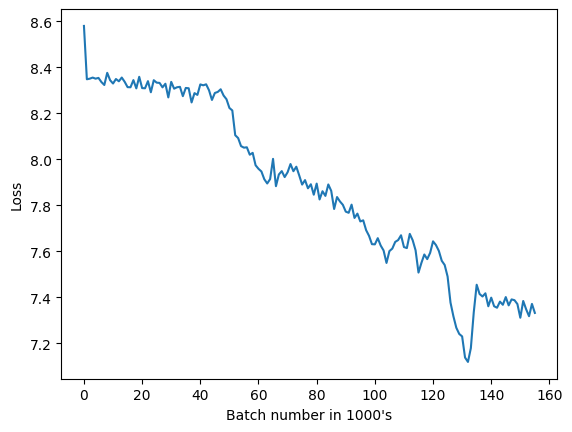

In [34]:
# plot a graph of loss on y axis and batch count on x axis
import matplotlib.pyplot as plt

# compute average each 1000th batch
loss_history_np = np.array(loss_history)
# remove last 59 elements
loss_history_np = loss_history_np[:-59]
loss_history_np = np.mean(loss_history_np.reshape(-1, 1000), axis=1)
# plot only 1000th batch
plt.plot(loss_history_np)
plt.xlabel("Batch number in 1000's")
plt.ylabel("Loss")
plt.show()

In [35]:
# Save the model
model_file_name = "NextItemPredTransformer_2.pt"
torch.save(model, model_file_name)


In [87]:

test_ratings_df= pd.read_pickle(r"lastXRatings.pkl",  compression= 'gzip')

# print the first 5 rows of the dataframe


# drop ratings which are 0s

test_ratings_df = test_ratings_df[test_ratings_df["rating"] != 0]

test_ratings_df.head()

,userId,movieId,rating,timestamp
66,4,1422,1,1042674861
199,7,106489,1,1486253996
154,7,2858,1,1486254186
210,8,318,1,1013444101
215,8,653,1,1013444101


In [88]:
print(len(test_ratings_df["movieId"].unique()))

# print number of unique items in all_movie_ids

print(len(all_movie_ids))

# get missing items in train_ratings_df

missing_items = set(test_ratings_df["movieId"].unique()) - set(all_movie_ids)

# remove the missing items from train_ratings_df

test_ratings_df = test_ratings_df[~test_ratings_df["movieId"].isin(missing_items)]

# print the new number of unique items in train_ratings_df

print(len(test_ratings_df["movieId"].unique()))

# remove all movies which are not in all_movie_ids

test_ratings_df = test_ratings_df[test_ratings_df["movieId"].isin(all_movie_ids)]

# print the new number of unique items in train_ratings_df

print(len(test_ratings_df["movieId"].unique()))

8565
9902
8564
8564


In [89]:
# Combine train_ratings_df and test_ratings_df on userId key

combined_ratings_df = pd.concat([train_ratings_df, test_ratings_df], axis=0)

# remove users which aren't present in train_ratings_df

combined_ratings_df = combined_ratings_df[combined_ratings_df["userId"].isin(train_ratings_df["userId"])]

In [90]:
# print number of unique users in combined_ratings_df

print(len(combined_ratings_df["userId"].unique()))

127878


In [91]:
# apply tokenizer_encode_item_ids to the movie ids column
user_id_to_movie_ids_eval = combined_ratings_df.groupby("userId")["movieId"].apply(list).apply(tokenizer.encode_items).to_dict()
user_id_to_rating_times_eval = combined_ratings_df.groupby("userId")["timestamp"].apply(list).to_dict()

# take last 50 ratings for each user
for user_id in user_id_to_movie_ids_eval:
    user_id_to_movie_ids_eval[user_id] = user_id_to_movie_ids_eval[user_id][-max_rating_sequence_length:]
    user_id_to_rating_times_eval[user_id] = user_id_to_rating_times_eval[user_id][-max_rating_sequence_length:]

In [92]:
user_items_vectors_eval = []
user_rating_times_vectors_eval = []
encoded_user_ids_eval = []

for user_id in user_id_to_movie_ids_eval.keys():
    encoded_user_ids_eval.append(tokenizer.encode_user(user_id))
    user_items_vectors_eval.append(np.array(user_id_to_movie_ids_eval[user_id]))
    user_rating_times_vectors_eval.append(np.array(user_id_to_rating_times_eval[user_id]))

In [93]:
from NextItemPredDataset import NextItemPredDataset
from utils import prepare_test_data_for_next_item_pred_transformer
# Create a dataset
dataset = NextItemPredDataset(
    prepare_test_data_for_next_item_pred_transformer(encoded_user_ids_eval, user_items_vectors_eval, user_rating_times_vectors_eval, max_seq_len=max_rating_sequence_length)
)
print(len(encoded_user_ids))

127878


In [94]:
# load the model
trained_model = torch.load(model_file_name)

In [95]:
# Create a dataloader
batch_size = 1
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=False, num_workers=0
)



  1%|          | 1320/127878 [2:30:36<240:39:29,  6.85s/it] 


In [96]:
# use cpu 
device = torch.device("cpu")
trained_model.to(device)

NextItemPredTransformer(
  (decoder): ItemDecoder(
    (items_embedding): Embedding(9904, 40)
    (users_embedding): Embedding(127878, 40)
    (time_embedding): Sequential(
      (0): Linear(in_features=52, out_features=2080, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(52, 40))
      (2): ReLU()
    )
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=40, out_features=40, bias=True)
          (key): Linear(in_features=40, out_features=40, bias=False)
          (value): Linear(in_features=40, out_features=40, bias=True)
          (out): Linear(in_features=40, out_features=40, bias=True)
        )
        (attn_ln): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=40, out_features=160, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=160, out_features=40, bias=True)
        )
        (mlp_ln):

In [97]:
import datetime

# convert all titles to numpy array
def map_movie_ids_to_titles(movie_ids, mapping_dict):
    return [mapping_dict[movie_id] for movie_id in movie_ids]
    

In [98]:
# load movies_df.pkl to an object

movies_df= pd.read_pickle(r"movies_df.pkl", compression= 'gzip')

In [99]:
# load top 10 of df
movies_df.head(10)
# get release_date of movieId 1
movies_df[movies_df["movieId"] == 1]["release_date"].values[0]

815011200.0

In [112]:
def get_movie_release_date(movie_id):
    unix_timestamp = movies_df[movies_df["movieId"] == movie_id]["release_date"].values[0]
    # if negative convert to positive
    if unix_timestamp < 0:
        date_time_obj = datetime.datetime(1970, 1, 1) + datetime.timedelta(seconds=(-3739996800000/1000))
        return date_time_obj.strftime("%d/%m/%Y %H:%M:%S")
    return  datetime.datetime.fromtimestamp(unix_timestamp).strftime("%d/%m/%Y %H:%M:%S")

In [113]:
def check_if_movie_is_in_the_future(prediction_time, movie_id):
    # get release date of movie_id
    release_date = movies_df[movies_df["movieId"] == movie_id]["release_date"].values[0]

    # if release data is negative convert to positive   
    if release_date < 0:
        return False
    # if release data is None, return False
    if release_date is None:
        return False
    # convert both to datetime
    prediction_time_str = datetime.datetime.fromtimestamp(prediction_time)
    try:
        release_date_str = datetime.datetime.fromtimestamp(release_date)
    except:
        return False
    # convert to human readable
    prediction_time_str = datetime.datetime.strptime(prediction_time_str.strftime("%d/%m/%Y %H:%M:%S"), "%d/%m/%Y %H:%M:%S")
    release_date_str = datetime.datetime.strptime(release_date_str.strftime("%d/%m/%Y %H:%M:%S"), "%d/%m/%Y %H:%M:%S")
    if prediction_time < release_date:
        return True
    else:
        return False

In [116]:
# set model to eval mode
trained_model.eval()
results = []
for batch in dataloader:
        try:
                # Get the inputs; data is a list of [inputs, labels]
                user_ids, items, times, pred_index, true_item_id = batch
                pred_times = torch.gather(times, 1, pred_index.unsqueeze(1))
                # squeeze the pred_times to remove the extra dim
                pred_times = torch.squeeze(pred_times, dim=1)

                # convert to device
                user_ids = user_ids.to(device)
                items = items.to(device)
                times = times.to(device)
                pred_index = pred_index.to(device)
                true_item_id = true_item_id.to(device)
                pred_times = pred_times.to(device)

                # decode items with tokenizer
                # remove batch dim
                items_as_list = torch.squeeze(items, dim=0)
                # convert to list
                items_as_list = items_as_list.tolist()
                # filter out all zeros and 1s
                items_as_list = list(filter(lambda x: x != 0 and x != 1, items_as_list))
                decoded_items = tokenizer.decode_items(items_as_list)
                # decode true_item_id with tokenizer
                decoded_true_item_id = tokenizer.decode_item(true_item_id.item())
                # print titles of the items
                items_in_sequence_titles = map_movie_ids_to_titles(decoded_items, movie_id_to_title)
                # print title of the true item
                true_title = movie_id_to_title[decoded_true_item_id]
                

                # Forward pass
                outputs = trained_model(items, user_ids, times, pred_times)
                relevant_outputs = torch.gather(outputs, 1, pred_index.unsqueeze(1).unsqueeze(2).expand(-1, -1, vocab_size))
                
                # Squeeze dim 1 for relevant_outputs
                relevant_outputs = torch.squeeze(relevant_outputs, dim=1)
                # do a softmax on the outputs
                relevant_outputs = torch.softmax(relevant_outputs, dim=1)
                # remove the batch dim
                relevant_outputs = torch.squeeze(relevant_outputs, dim=0)
                # get the top 10 items and their scores
                top_100_items = torch.topk(relevant_outputs, 100)
                scores, indices = top_100_items
                indices = indices.tolist()
                try:
                        sos_index = indices.index(0)
                except:
                        sos_index = -1
                try:
                        eos_index = indices.index(1)
                except:
                        eos_index = -1
                top_100_item_ids = list(filter(lambda x: x != 0 and x != 1, indices))

                # filter out zeros and 1s

                # remove sos and eos
                # get the top 10 item scores
                top_100_item_scores = scores.tolist()
                # remove indices which are present in items

                # decode the top 10 item ids
                decoded_top_100_item_ids = tokenizer.decode_items(top_100_item_ids)
                decoded_titles = map_movie_ids_to_titles(decoded_top_100_item_ids, movie_id_to_title)
                dt_object = datetime.datetime.fromtimestamp(pred_times.item())

                # add sos and eos to the titles by their index if they exist
                if sos_index != -1:
                        decoded_titles.insert(sos_index, "<sos>")
                if eos_index != -1:
                        decoded_titles.insert(eos_index, "<eos>")
                
                relevant_decoded_items = []
                relevant_scores = []
                relevant_titles = []
                for i in range(len(decoded_top_100_item_ids)):
                        if decoded_top_100_item_ids[i] not in decoded_items and not check_if_movie_is_in_the_future(pred_times.item(), decoded_top_100_item_ids[i]):
                                relevant_decoded_items.append(decoded_top_100_item_ids[i])
                                relevant_scores.append(top_100_item_scores[i])
                                relevant_titles.append(decoded_titles[i])
                
                # take 10 items and scores
                relevant_decoded_items = relevant_decoded_items[:10]
                release_dates_of_relevant_items = list(map(get_movie_release_date, relevant_decoded_items))
                relevant_titles = relevant_titles[:10]
                relevant_scores = relevant_scores[:10]
                rating_time = dt_object.strftime("%d/%m/%Y %H:%M:%S")
                # get release times of relevant relevant_decoded_items from movies_df


                # print the top 10 items and their scores
                top_100_predicted_titles = map_movie_ids_to_titles(decoded_top_100_item_ids, movie_id_to_title)
                current_map = {
                        "true_title": true_title,
                        "items_in_sequence_titles": items_in_sequence_titles,
                        "top_10_predicted_titles": relevant_titles,
                        "top_10_item_scores": relevant_scores,
                        "release_dates_of_top_10": release_dates_of_relevant_items,
                        "rating_time": rating_time
                }
                results.append(current_map)
        except:
                continue
  

  1%|          | 1274/127878 [27:45<2133:18:38, 60.66s/it]

KeyboardInterrupt: 